In [2]:
# Useful libraries
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import Env
import gymnasium as gym
from gymnasium import spaces
from gym.spaces import Discrete, Box
import numpy as np
import pygame
import random
import gym

In [ ]:
# Platoon class
class Platoon:
    def __init__(self, platoon_members):
        # Members of the platoon
        self.platoon_members = platoon_members

    def split_platoon(self, exit_index):
        # Case 1: First agent (leader) 
        if exit_index == len(self.platoon_members) - 1 and len(self.platoon_members) > 1 and \
        self.platoon_members[exit_index-1].destination != self.platoon_members[-1].destination:
            for member in self.platoon_members:
                member.is_leader = False
            rear_platoon_members = self.platoon_members[:-1]
            front_platoon_members = [self.platoon_members[-1]]
            rear_platoon_members[-1].is_leader = True 
            new_rear_platoon = Platoon(rear_platoon_members)
            self.platoon_members = front_platoon_members
            self.platoon_members[-1].is_leader = True 
            return None, new_rear_platoon
        
        # Case 2: Agent in the middle
        elif 0 < exit_index < len(self.platoon_members) - 1:
            # Subcases
            if self.platoon_members[exit_index-1].destination != self.platoon_members[-1].destination \
            and self.platoon_members[exit_index+1].destination != self.platoon_members[-1].destination:
                for member in self.platoon_members:
                    member.is_leader = False
                rear_platoon_members = self.platoon_members[:exit_index]
                exiting_agent = self.platoon_members[exit_index]
                front_platoon_members = self.platoon_members[exit_index + 1:]
                new_exiting_platoon = Platoon([exiting_agent])
                new_exiting_platoon.platoon_members[-1].is_leader = True
                rear_platoon_members[-1].is_leader = True 
                new_rear_platoon = Platoon(rear_platoon_members)
                self.platoon_members = front_platoon_members
                self.platoon_members[-1].is_leader = True 
                return new_exiting_platoon, new_rear_platoon
            elif self.platoon_members[exit_index-1].destination != self.platoon_members[-1].destination:
                for member in self.platoon_members:
                    member.is_leader = False
                rear_platoon_members = self.platoon_members[:exit_index]
                front_platoon_members = self.platoon_members[exit_index:]
                rear_platoon_members[-1].is_leader = True 
                new_rear_platoon = Platoon(rear_platoon_members)
                self.platoon_members = front_platoon_members
                self.platoon_members[-1].is_leader = True 
                return None, new_rear_platoon
            elif self.platoon_members[exit_index+1].destination != self.platoon_members[-1].destination:
                for member in self.platoon_members:
                    member.is_leader = False
                rear_platoon_members = self.platoon_members[:exit_index + 1]
                front_platoon_members = self.platoon_members[exit_index + 1:]
                rear_platoon_members[-1].is_leader = True 
                new_rear_platoon = Platoon(rear_platoon_members)
                self.platoon_members = front_platoon_members
                self.platoon_members[-1].is_leader = True 
                return None, new_rear_platoon

        return None, None


class Agent:
    def __init__(self, position, speed, destination, is_leader=False, speed_min=0.25, speed_max=1.0, acceleration=0.005):
        self.position = position
        self.distance = 0
        self.speed = speed
        self.destination = destination
        self.is_leader = is_leader
        self.done = False
        self.velocities = []
        self.direction = 0
        self.speed_min = speed_min
        self.speed_max = speed_max
        self.acceleration = acceleration
        self.target_speed = 1.0
        self.deviated = False

    def update_position(self):
        self.position += self.speed
        self.distance += self.speed

    def update_speed(self, action=None):
        if self.is_leader:
            if abs(self.speed - self.target_speed) < 0.01:
                self.speed = self.target_speed
            elif self.speed < self.target_speed:
                self.speed = min(self.speed + self.acceleration, self.target_speed)
            elif self.speed > self.target_speed:
                self.speed = max(self.speed - self.acceleration, self.target_speed)
        else:
            if action == 0:
                self.speed = max(0, self.speed - 0.005)
            elif action == 2:
                self.speed = min(1.0, self.speed + 0.005)
        self.velocities.append(self.speed)

class FollowLeaderEnv(gym.Env):
    def __init__(self, num_agents, visualize=False):
        super(FollowLeaderEnv, self).__init__()
        self.num_agents = num_agents

        # Define action and observation spaces
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
        
        # Initialize agents
        initial_position = 50.0
        leader_speed = 0.0
        self.agents = [
            Agent(position=initial_position + 50 * (i),
                  speed=leader_speed,
                  destination=np.random.randint(2),
                  is_leader=True if i == num_agents - 1 else False)
            for i in range(num_agents)
        ]

        # Initialize platoons with the created agents
        self.platoons = [Platoon(self.agents)]
        self.completed_platoons = []  # Track completed platoons
        self.target_distance = 50.0
        if visualize:
            self.init_pygame()

    # Visualize
    def init_pygame(self):
        print("Initializing Pygame...")
        pygame.init()
        self.screen = pygame.display.set_mode((1200, 850))
        self.clock = pygame.time.Clock()
        self.is_pygame_initialized = True
        pygame.font.init()
        self.font = pygame.font.Font(None, 36)

    # Request Coupling
    def check_distance_and_request_coupling(self, rear_platoon):
        # Initialize variables to track the closest front platoon
        closest_platoon = None
        min_distance = float('inf')
        # Get the position of the first agent in the rear platoon
        rear_first_agent = rear_platoon.platoon_members[-1]
        # Loop through each platoon to find the closest eligible front platoon
        for front_platoon in self.platoons:
            # Skip if this is the rear platoon itself or if the front platoon is behind
            if front_platoon is rear_platoon:
                continue
            front_last_agent = front_platoon.platoon_members[0]
            # Only check platoons with the same destination
            if rear_first_agent.destination == front_last_agent.destination and rear_first_agent.distance < front_last_agent.distance:
                # Check if this is the closest platoon within the coupling threshold
                d = front_last_agent.distance - rear_first_agent.distance
                if d < 300 and d < min_distance:
                    min_distance = d
                    closest_platoon = front_platoon

        # Perform coupling if a valid front platoon is found
        if closest_platoon:
            # Merge the rear platoon behind the closest front platoon
            rear_platoon.platoon_members.extend(closest_platoon.platoon_members)
            self.platoons.remove(closest_platoon)
            for member in rear_platoon.platoon_members:
                member.is_leader = False
            rear_platoon.platoon_members[-1].is_leader = True
            # Set target speed for safe coupling
            rear_platoon.platoon_members[-1].target_speed = 0.5

    def step(self, platoon, action, agent_idx):
        agent = platoon.platoon_members[agent_idx]
        leader = platoon.platoon_members[agent_idx + 1]
        
        # Deviation
        if agent.direction == 0 and agent.position >= 500 and agent.deviated == False:
            if agent.destination == 1:
                agent.position = 150
                agent.direction = 1  
            agent.deviated = True 
            new_exiting_platoon, new_rear_platoon = platoon.split_platoon(agent_idx)
            if new_exiting_platoon:
                self.platoons.append(new_exiting_platoon)
            if new_rear_platoon:
                self.platoons.append(new_rear_platoon)
            return [], 0, False, {}

        agent.update_speed(action)
        agent.update_position()
        if agent.direction == leader.direction:
            distance_to_leader = leader.position - agent.position
        else:
            distance_to_leader = 500 - agent.position + (leader.position - 150) 
        done = False

        # Check for episode ending (all platoons arrived at destination)
        if (platoon.platoon_members[-1].direction == 0 and platoon.platoon_members[-1].position >= 1150) or \
        (platoon.platoon_members[-1].direction == 1 and platoon.platoon_members[-1].position >= 800):
            # Mark platoon as completed if it's still in self.platoons
            if platoon in self.platoons:
                self.completed_platoons.append(platoon)
                self.platoons.remove(platoon)
        
        # End the episode when all platoons are done
        if not self.platoons: 
            done = True

        state = np.array([distance_to_leader, agent.speed, leader.speed], dtype=np.float32)
        agent.velocities.append(agent.speed)
        return state, 0, done, {}


    def update_leader_speed(self, platoon):

        # Check if has to keep waiting for followers or speed up to target speed
        any_agent_behind = any(
            (platoon.platoon_members[i + 1].position - platoon.platoon_members[i].position > self.target_distance + 12)
            for i in range(len(platoon.platoon_members) - 1)
        )
        leader = platoon.platoon_members[-1]
        if not any_agent_behind:
            leader.target_speed = 1.0 

        leader.update_position()
        leader.update_speed()

        leader.velocities.append(leader.speed)

        # Deviation
        if leader.direction == 0 and leader.position >= 500 and leader.deviated == False:
            if leader.destination == 1:
                leader.position = 150
                leader.direction = 1  
            leader.deviated = True 
            new_exiting_platoon, new_rear_platoon = platoon.split_platoon(len(platoon.platoon_members)-1)
            if new_exiting_platoon:
                self.platoons.append(new_exiting_platoon)
            if new_rear_platoon:
                self.platoons.append(new_rear_platoon)

        if not self.platoons:  # Check if there are no active platoons left
            return True
        else:
            return False

    # Visualization
    def render(self):
        if not hasattr(self, 'screen'):
            return
        self.screen.fill((0, 0, 0))
        pygame.draw.line(self.screen, (30, 30, 30), (50, 150), (1150, 150), 5)
        pygame.draw.line(self.screen, (30, 30, 30), (500, 150), (500, 800), 5)
        pygame.draw.circle(self.screen, (255, 0, 0), (1150, 150), 10)
        pygame.draw.circle(self.screen, (255, 0, 0), (500, 800), 10)
        
        for platoon in self.platoons:
            for agent in platoon.platoon_members:
                if agent.direction == 0:
                    x, y, z, k = int(agent.position) - 6, 147, 12, 6
                else:
                    x, y, z, k = 497, int(agent.position) - 6, 6, 12
                if agent.destination == 0:
                    pygame.draw.rect(self.screen, (255, 105, 0) if agent.is_leader else (255, 200, 0), pygame.Rect(x, y, z, k))
                else:
                    pygame.draw.rect(self.screen, (0, 255, 0) if agent.is_leader else (100, 255, 100), pygame.Rect(x, y, z, k))

        # Show leader speed text
        y_offset = 10
        for i, platoon in enumerate(self.platoons):
            leader_speed = platoon.platoon_members[-1].speed
            text = f"Platoon {i+1} - Leader Speed: {round(leader_speed, 3)}"
            speed_text = self.font.render(text, True, (255, 255, 255))
            self.screen.blit(speed_text, (10, y_offset))
            y_offset += 20
        pygame.display.flip()
        self.clock.tick(60)

    # Close visualization
    def close(self):
        if self.is_pygame_initialized:
            print("Closing Pygame...")
            pygame.quit()
            self.is_pygame_initialized = False

In [60]:
# Neural network for Q-learning (DQN)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
import time

# Initialize the environment with 6 agents and visualization
env = FollowLeaderEnv(num_agents=6, visualize=True)

# Get the state and action dimensions from the environment
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize a new DQN network for testing
dqn_test = DQN(state_dim, action_dim)

# Load the trained model's weights
dqn_test.load_state_dict(torch.load("policy_net_weights_final5.pth"))

# Set the model to evaluation mode 
dqn_test.eval()

# Loop to run the episode
done = False
while not done:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True

    time.sleep(0.05)

    # Iterate through each platoon, and use a while loop to handle dynamic changes in platoons
    platoon_index = 0
    while platoon_index < len(env.platoons):
        platoon = env.platoons[platoon_index]
        
        # Iterate through agents in the platoon
        agent_index = 0
        while agent_index < len(platoon.platoon_members):
            agent = platoon.platoon_members[agent_index]
            
            if agent.is_leader or agent_index == len(platoon.platoon_members) - 1:
                agent_index += 1  
                continue
            
            with torch.no_grad():
                next_agent = platoon.platoon_members[agent_index + 1]
                if agent.direction == next_agent.direction:
                    distance_to_leader = next_agent.position - agent.position
                else:
                    distance_to_leader = 500 - agent.position + (next_agent.position - 150) 
                
                # If withing coupling communication distance use the model, else speed up until speed limit
                if distance_to_leader > 100:
                    action = 2
                else:
                    action = torch.argmax(dqn_test(torch.FloatTensor([distance_to_leader, agent.speed, next_agent.speed]))).item()

            # Take a step in the environment
            _, _, done, _ = env.step(platoon, action, agent_index)

            if done == True:
                break
            
            agent_index += 1

        # After iterating over agents, update the leader’s speed and check for coupling
        done = env.update_leader_speed(platoon)
        if done == True:
            break
        env.check_distance_and_request_coupling(platoon)
        
        # Re-check platoon list length if a split or merge occurred
        if platoon_index < len(env.platoons):
            platoon_index += 1

    env.render()

env.close()


Initializing Pygame...
Closing Pygame...


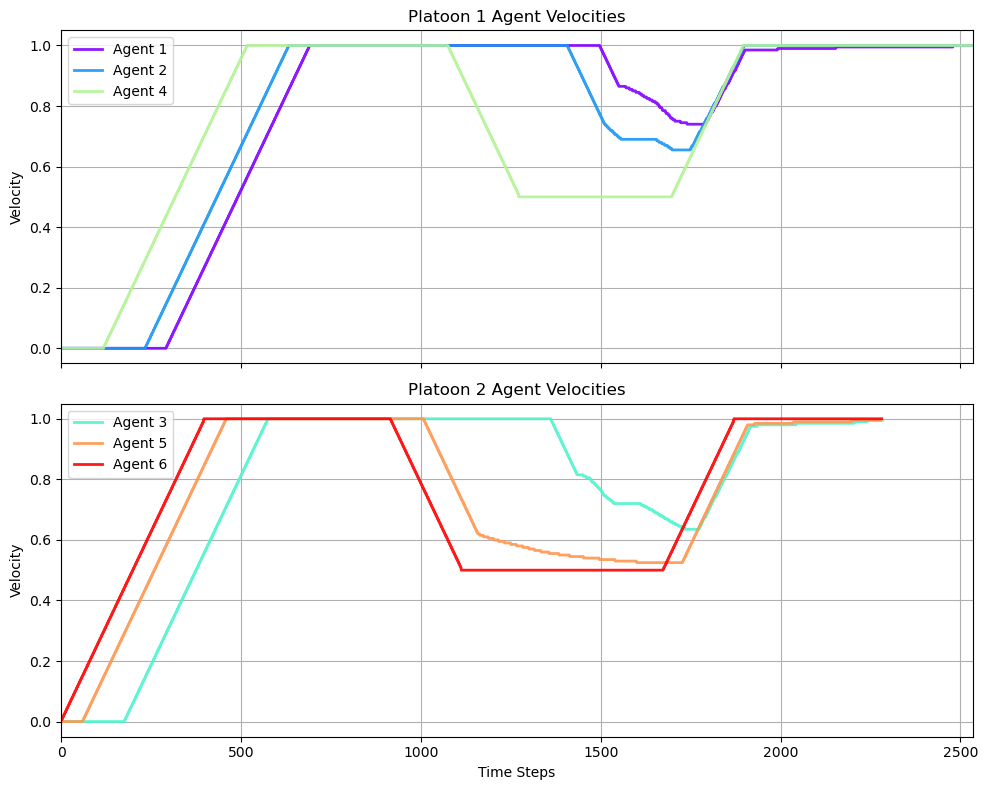

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Define platoons and colors
platoon1 = {1, 2, 4}
platoon2 = {3, 5, 6}
agent_colors = plt.cm.rainbow(np.linspace(0, 1, len(env.agents))) # Unique colors for agents
max_length = max(len(agent.velocities) for agent in env.agents)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for Platoon 1
for count, (agent, color) in enumerate(zip(env.agents, agent_colors), start=1):
    if count in platoon1:
        axes[0].plot(agent.velocities, label=f'Agent {count}', color=color, linewidth=2, alpha=0.9)

axes[0].set_title('Platoon 1 Agent Velocities')
axes[0].set_ylabel('Velocity')
axes[0].legend()
axes[0].grid()

# Plot for Platoon 2
for count, (agent, color) in enumerate(zip(env.agents, agent_colors), start=1):
    if count in platoon2:
        axes[1].plot(agent.velocities, label=f'Agent {count}', color=color, linewidth=2, alpha=0.9)

axes[1].set_title('Platoon 2 Agent Velocities')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Velocity')
axes[1].legend()
axes[1].grid()

axes[1].set_xlim(0, max_length)
plt.tight_layout()
plt.show()
